## Project 5 : Classification

## Instructions

### Description

Practice classification on the Titanic dataset.

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.


In [41]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Introduction

On April 15, 1912, the largest passenger liner ever made collided with an iceberg during her maiden voyage. When the Titanic sank it killed 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships. One of the reasons that the shipwreck resulted in such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others.

Intro Videos: 
https://www.youtube.com/watch?v=3lyiZMeTKIo
and
https://www.youtube.com/watch?v=ItjXTieWKyI 

The `titanic_data.csv` file contains data for `887` of the real Titanic passengers. Each row represents one person. The columns describe different attributes about the person including whether they survived (`0=No`), their age, their passenger-class (`1=1st Class, Upper`), gender, and the fare they paid (£s*). For more on the currency: http://www.statisticalconsultants.co.nz/blog/titanic-fare-data.html

We are going to try to see if there are correlations between the feature data provided (find a best subset of features) and passenger survival.

### Problem 1: Load and understand the data (35 points)

#### Your task (some of this is the work you completed for L14 - be sure to copy that work into here as needed)
Conduct some preprocessing steps to explore the following and provide code/answers in the below cells:
1. Load the `titanic_data.csv` file into a pandas dataframe
2. Explore the data provided (e.g., looking at statistics using describe(), value_counts(), histograms, scatter plots of various features, etc.) 
3. What are the names of feature columns that appear to be usable for learning?
4. What is the name of the column that appears to represent our target?
5. Formulate a hypothesis about the relationship between given feature data and the target
6. How did Pclass affect passenngers' chances of survival?
7. What is the age distribution of survivors?

In [42]:
# Step 1. Load the `titanic_data.csv` file into a pandas dataframe
df = pd.read_csv ('titanic_data.csv')
#print(df)

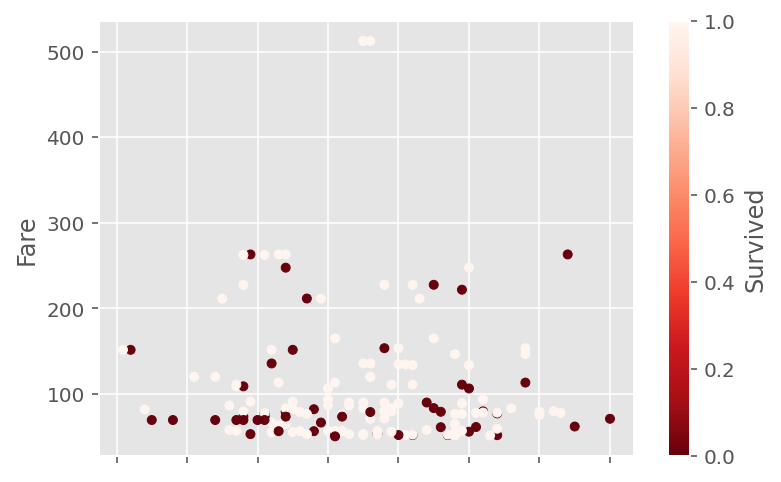

In [43]:
# Step 2. Explore the data provided (e.g., looking at statistics using describe(), value_counts(), histograms, scatter plots of various features, etc.) 
#df.describe

# How many survived?
df['Survived'].value_counts().head()

# #Plotting the correlation between age and fare
titanicSubset = df[df['Fare'] > 50]
titanicSubset.describe()

titanicSubset.plot(kind='scatter', x='Age', y='Fare', c = 'Survived', colormap='Reds_r') 
plt.show()


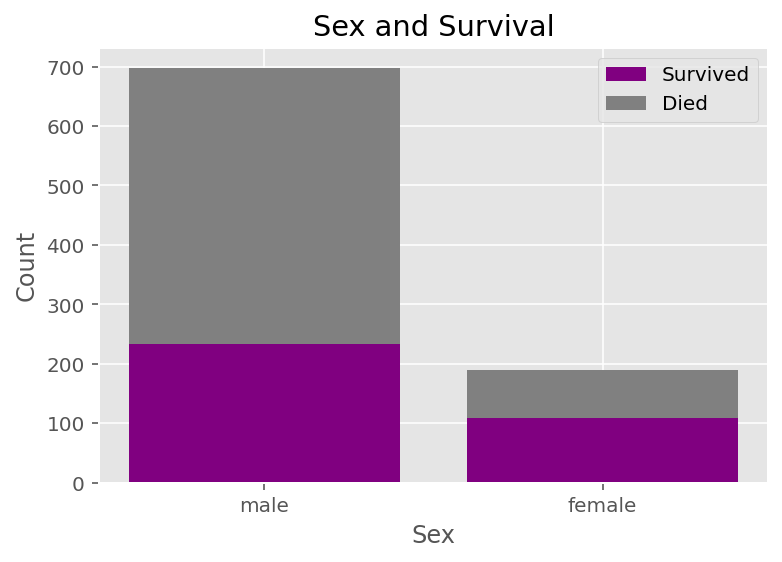

In [44]:
# Plotting the correlation between female and male survival rate
test=df['Sex'].value_counts()
labels = test.keys()
plt.bar(labels,df.where(df['Survived']==1)['Sex'].value_counts(), color='purple')
plt.bar(labels,df.where(df['Survived']==0)['Sex'].value_counts(), 
        bottom=df.where(df['Survived']==1)['Sex'].value_counts(), color='gray')
legend = ["Survived","Died"]
plt.legend(legend)
plt.xticks(labels)
plt.xlabel("Sex")
plt.ylabel("Count")
plt.title("Sex and Survival")
plt.show()

---

**Edit this cell to provide answers to the following steps:**

---

Step 3. What are the names of feature columns that appear to be usable for learning?
<br><br> Almost all the columns are plotable, but I'm not sure if names can be plotted as well.

Step 4. What is the name of the column that appears to represent our target?
<br><br> Survived

Step 5. Formulate a hypothesis about the relationship between given feature data and the target
<br><br> Age and sex might have the strongest correlation because of the "women and children first" mentality.


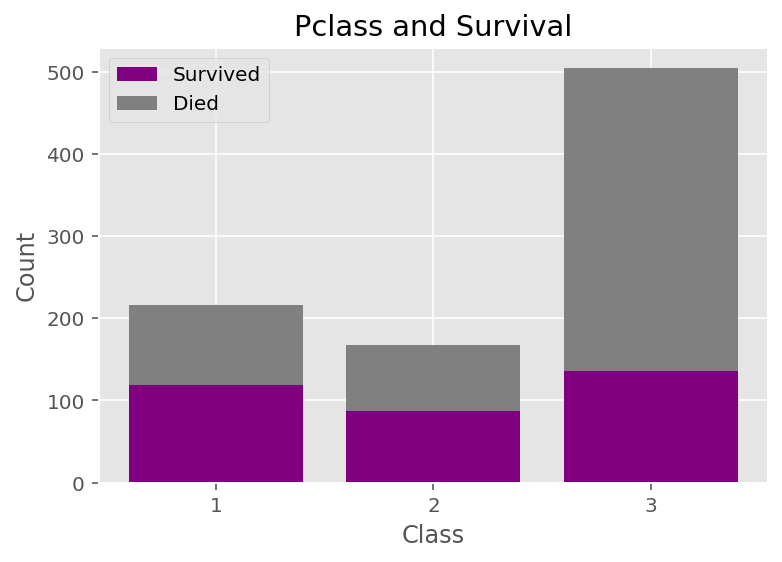

In [45]:
#Step 6. How did Pclass affect passenngers' chances of survival?
#Show your work with a bar plot, dataframe selection, or visual of your choice.
test=df['Pclass'].value_counts()
labels = test.keys()
plt.bar(labels,df.where(df['Survived']==1)['Pclass'].value_counts(), color='purple')
plt.bar(labels,df.where(df['Survived']==0)['Pclass'].value_counts(), bottom = df.where(df['Survived']==1)['Pclass'].value_counts(), color='gray')
legend = ["Survived","Died"]
plt.legend(legend)
plt.title("Pclass and Survival")
plt.xticks(labels)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

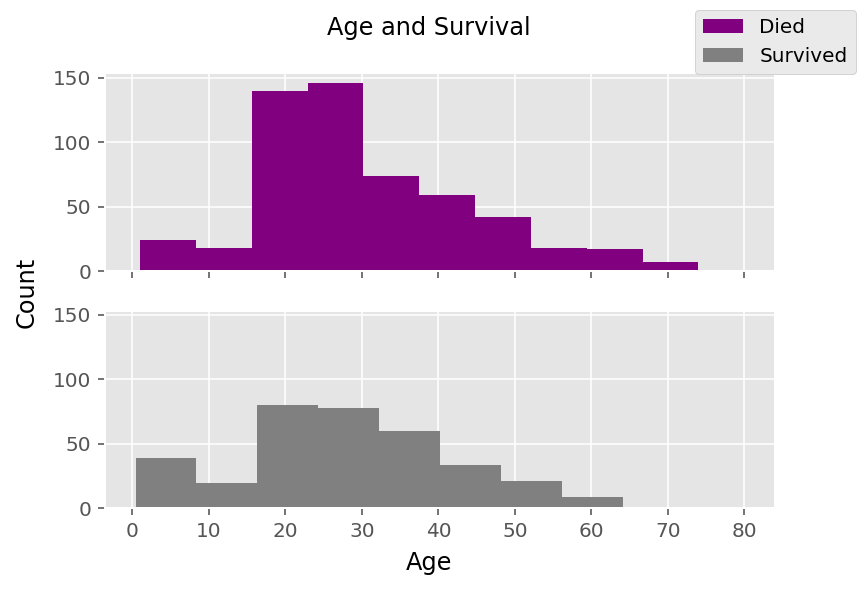

In [46]:
#Step 7. What is the age distribution of survivors?
#Show your work with a dataframe operation and/or histogram plot.
test=df['Age'].value_counts()
labels = test.keys()
fig, (ax1, ax2) = plt.subplots(2, sharex=True, sharey = True)
fig.suptitle('Age and Survival')
ax1.hist(df.where(df['Survived']==0)['Age'], color='purple', label = "Died")
ax2.hist(df.where(df['Survived']==1)['Age'], color='gray', label = "Survived")
fig.legend()
fig.supxlabel("Age")
fig.supylabel("Count")
plt.show()

### Problem 2: transform the data (10 points)
The `Sex` column is categorical, meaning its data are separable into groups, but not numerical. To be able to work with this data, we need numbers, so you task is to transform the `Sex` column into numerical data with pandas' `get_dummies` feature and remove the original categorical `Sex` column.

In [47]:
df = pd.get_dummies(df, columns = ["Sex"])
df = df.drop(['Sex_male'], axis=1)
df.head()

,Survived,Pclass,Name,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare,Sex_female
0,0,3,Mr. Owen Harris Braund,22.0,1,0,7.2500,0
1,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,38.0,1,0,71.2833,1
2,1,3,Miss. Laina Heikkinen,26.0,0,0,7.9250,1
3,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,35.0,1,0,53.1000,1
4,0,3,Mr. William Henry Allen,35.0,0,0,8.0500,0


### Problem 3: Classification (30 points)
Now that the data is transformed, we want to run various classification experiments on it. The first is `K Nearest Neighbors`, which you will conduct by:

1. Define input and target data by creating lists of dataframe columns (e.g., inputs = ['Pclass', etc.)
2. Split the data into training and testing sets with `train_test_split()`
3. Create a `KNeighborsClassifier` using `5` neighbors at first (you can experiment with this parameter)
4. Train your model by passing the training dataset to `fit()`
5. Calculate predicted target values(y_hat) by passing the testing dataset to `predict()`
6. Print the accuracy of the model with `score()`

** Note: If you get a python warning as you use the Y, trainY, or testY vector in some of the function calls about "DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, )", you can look up how to use trainY.values.ravel() or trainY.values.flatten() or another function, etc.

In [48]:
inputs = df[["Pclass","Age","Siblings/Spouses Aboard","Sex_female"]]
target = df["Survived"]

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(inputs, target, test_size=0.7)

In [50]:
from sklearn.neighbors import KNeighborsClassifier
k = 5
model_neighbors = KNeighborsClassifier(k)
model_neighbors.fit(X_train,y_train)
y_hat = model_neighbors.predict(X_test)
model_neighbors.score(X_test, y_test)

0.7262479871175523

### Problem 4: Cross validation, classification report (15 points)
- Using the concepts from the 17-model_selection slides and the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function from scikit-learn, estimate the f-score ([`f1-score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) (you can use however many folds you wish). To get `cross_val_score` to use `f1-score` rather than the default accuracy measure, you will need to set the `scoring` parameter and use a scorer object created via [`make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer).  Since this has a few parts to it, let me just give you that parameter: ```scorerVar = make_scorer(f1_score, pos_label=1)```

- Using the concepts from the end of the 14-classification slides, output a confusion matrix.

- Also, output a classification report [`classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) from sklearn.metrics showing more of the metrics: precision, recall, f1-score for both of our classes.

In [51]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn import model_selection

# Getting the f1-score through cross validation
scorerVar = make_scorer(f1_score, pos_label=1)
score = model_selection.cross_val_score(model_neighbors, X_test, y_test, cv = 5, scoring = scorerVar)
fValue = sum(score)/len(score)
print(f"f1-value: ", fValue)

# Confusion Matrix
matrix = sk.metrics.confusion_matrix(y_test, y_hat)
print(f"confusion matrix: ", matrix)

# Classification Report
report = metrics.classification_report(y_test, y_hat)
print(f"classification report: ", report )

f1-value:  0.6639665574825893
confusion matrix:  [[337  44]
 [126 114]]
classification report:                precision    recall  f1-score   support

           0       0.73      0.88      0.80       381
           1       0.72      0.47      0.57       240

    accuracy                           0.73       621
   macro avg       0.72      0.68      0.69       621
weighted avg       0.73      0.73      0.71       621



### Problem 5: Support Vector Machines (15 points)
Now, repeat the above experiment using the using a Support Vector classifier [`SVC`](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) with default parameters (RBF kernel) model in scikit-learn, and output:

- The fit accuracy (using the `score` method of the model)
- The f-score (using the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function)
- The confusion matrix
- The precision, recall, and f-measure for the 1 class (you can just print the results of the [`classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function from sklearn.metrics)

In [52]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

#create a model object
SVMmodel = SVC(kernel='linear', C=10)

#train our model
SVMmodel.fit(X_train, y_train)

#evaluate the model 
testing = SVMmodel.score(X_test, y_test)
y_hat = SVMmodel.predict(X_test)
print(f"testing accuracy: ", testing)

#setup to get f-score and cv
scorerVar = make_scorer(f1_score, pos_label=1)
score = model_selection.cross_val_score(SVMmodel, X_test, y_test, cv = 5, scoring = scorerVar)
fValue = sum(score)/len(score)
print(f"f-score: ", fValue)

#confusion matrix
matrix = sk.metrics.confusion_matrix(y_test, y_hat)
print(f"confusion matrix: ", matrix)

#classification report
report = metrics.classification_report(y_test, y_hat)
print(f"classification report: ", report)

testing accuracy:  0.7809983896940419
f-score:  0.7011768788012624
confusion matrix:  [[326  55]
 [ 81 159]]
classification report:                precision    recall  f1-score   support

           0       0.80      0.86      0.83       381
           1       0.74      0.66      0.70       240

    accuracy                           0.78       621
   macro avg       0.77      0.76      0.76       621
weighted avg       0.78      0.78      0.78       621



### Problem 6: Logistic Regression (15 points)

Now, repeat the above experiment using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model in scikit-learn, and output:

- The fit accuracy (using the `score` method of the model)
- The f-score (using the [`cross_val_score`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function)
- The confusion matrix
- The precision, recall, and f-measure for the 1 class (you can just print the results of the [`classification_report`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) function from sklearn.metrics)

In [53]:
from sklearn.linear_model import LogisticRegression

#create a model object
logModel = LogisticRegression()

#train our model
logModel.fit(X_train, y_train)

#evaluate the model 
testing = logModel.score(X_test, y_test)
y_hat = logModel.predict(X_test)
print(f"testing accuracy: ", testing)

#setup to get f-score and cv
scorerVar = make_scorer(f1_score, pos_label=1)
score = model_selection.cross_val_score(model_svm, X_test, y_test, cv = 5, scoring = scorerVar)
fValue = sum(score)/len(score)
print(f"f-score: ", fValue)

#confusion matrix
matrix = sk.metrics.confusion_matrix(y_test, y_hat)
print(f"confusion matrix: ", matrix)

#classification report
report = metrics.classification_report(y_test, y_hat)
print(f"classification report: ", report)

testing accuracy:  0.8067632850241546
f-score:  0.7011768788012624
confusion matrix:  [[340  41]
 [ 79 161]]
classification report:                precision    recall  f1-score   support

           0       0.81      0.89      0.85       381
           1       0.80      0.67      0.73       240

    accuracy                           0.81       621
   macro avg       0.80      0.78      0.79       621
weighted avg       0.81      0.81      0.80       621



### Problem 7: Comparision and Discussion (5 points)
Edit this cell to provide a brief discussion (3-5 sentances at most):
1. What was the model/algorithm that performed best for you?
<br><br> The log model worked best since it had the highest accuracy score of 0.81
2. What feaures and parameters were used to achieve that performance?
<br><br> Age, Siblings/Spouse Aboard, Pclass, and Sex_female
3. What insights did you gain from your experimentation about the predictive power of this dataset and did it match your original hypothesis about the relationship between given feature data and the target?
<br><br> The "women and children first" mentality seems like it was applied on this dataset. The experimentation is not bad at predicting survivors for the titanic.


### Questionnaire
1) How long did you spend on this assignment?
<br> About half a day
2) What did you like about it? What did you not like about it?
<br> I liked the dataset and experimenting with the different visualization
3) Did you find any errors or is there anything you would like changed?
<br> No